In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math
import copy
import itertools
from tqdm import tqdm

from backend import *
from process import get_st_graph, get_srlg_cfp, get_fuggetlen_graph

In [32]:
network = 'usa_995'

srlgs, srlg_probs = get_SRLGs(f'PSRLGs/{network}.xml')
srlg_probs = np.asarray(srlg_probs)
srlg_lengths = np.asarray([len(srlg) for srlg in srlgs])

g_base = nx.read_gml(f'networks/{network}.gml', label="id")

if network == "italy_995":
    g_base.remove_edges_from([(19, 21, 1)])

pos = {node:(g_base.nodes[node]['Longitude'], g_base.nodes[node]['Latitude']) for node in g_base.nodes}

g_dual = nx.line_graph(g_base)
pos_dual = {node:(
                    (g_base.nodes[node[0]]["Longitude"] + g_base.nodes[node[1]]["Longitude"]) /2, 
                    (g_base.nodes[node[0]]["Latitude"] + g_base.nodes[node[1]]["Latitude"]) /2
                )
            for node in g_dual.nodes()
            }

In [33]:
resDict = {"simID":[], "start":[], "target":[],
            "len_sht":[], "err_sht":[],"avb_sht":[], 
            "len_djk":[], "err_djk":[], "avb_djk":[], 
            "len_fugg":[], "avb_fugg":[]}
resDictPaths = {}
simID = 0
hjk = {}

for s,t in tqdm(list(itertools.combinations(g_base.nodes, 2))):
    ### Create dual graph with start and end point ###
    g_dual_st, pos_dual_st = get_st_graph(g_base, srlgs, srlg_probs, g_dual, pos_dual, s, t)
    
    ### Create graph with fuggetlen cost method ###
    g_fuggetlen = get_fuggetlen_graph(g_base, srlgs, srlg_probs)

    ### Get safest path by dijkstra on dual graph ###
    djk_path = nx.dijkstra_path(g_dual_st, "Start", "Target", weight="cost")
    if len(djk_path) == 3:
        djk_err_prob = srlg_probs[srlgs.index({djk_path[1]})]
    else:
        djk_err_prob = np.sum([srlg_probs[srlgs.index({i})] for i in djk_path[1:-1]]) - math.prod([srlg_probs[srlgs.index({i})] for i in djk_path[1:-1]])
    djk_avb = np.prod([1- get_srlg_cfp(srlgs, srlg_probs, {i}) for i in djk_path[1:-1]])

    ### Get safest path by dijkstra with fuggetlen cost method ###
    djk_path_fuggetlen_nodes = nx.dijkstra_path(g_fuggetlen, s, t, "cost")
    
    djk_path_fuggetlen_edges2 = []
    one_edge_srlgs = [list(srlg)[0] for srlg in srlgs if len(srlg) == 1]
    for ind,val in enumerate(djk_path_fuggetlen_nodes[:-1]):
        if (val,djk_path_fuggetlen_nodes[ind+1],0) in one_edge_srlgs:
            djk_path_fuggetlen_edges2.append((val,djk_path_fuggetlen_nodes[ind+1],0))
        elif (djk_path_fuggetlen_nodes[ind+1],val,0) in one_edge_srlgs:
            djk_path_fuggetlen_edges2.append((djk_path_fuggetlen_nodes[ind+1],val,0))
        else:
            djk_path_fuggetlen_edges2.append((val,djk_path_fuggetlen_nodes[ind+1],0))
    
    
    djk_path_fuggetlen_edges = []
    for ind,val in enumerate(djk_path_fuggetlen_nodes[:-1]):
        for i in srlgs:
            if len(i) == 1:
                if (val in list(i)[0][:2]) & (djk_path_fuggetlen_nodes[ind+1] in list(i)[0][:2]):
                    djk_path_fuggetlen_edges.append(list(i)[0])
                else:
                    continue
            else:
                continue
    fuggetlen_avb = np.prod([1 - get_srlg_cfp(srlgs, srlg_probs, {i}) for i in djk_path_fuggetlen_edges])
    fuggetlen_avb2 = np.prod([1 - get_srlg_cfp(srlgs, srlg_probs, {i}) for i in djk_path_fuggetlen_edges2])

    if fuggetlen_avb2 > fuggetlen_avb:
        hjk.update({simID:[djk_path_fuggetlen_nodes, djk_path_fuggetlen_edges, djk_path_fuggetlen_edges2]})

    ### Get shortest path ###
    sht_path_nodes = nx.shortest_path(g_base, s,t)
    sht_path_edges = []
    for ind,val in enumerate(sht_path_nodes[:-1]):
        for i in srlgs:
            if len(i) == 1:
                if (val in list(i)[0][:2]) & (sht_path_nodes[ind+1] in list(i)[0][:2]): # Ezt átirni !!!!
                    sht_path_edges.append(list(i)[0])
                else:
                    continue
            else:
                continue
    
    if len(sht_path_edges) == 1:
        sht_err_prob = srlg_probs[srlgs.index({sht_path_edges[0]})]
    else:
        sht_err_prob = np.sum([srlg_probs[srlgs.index({i})] for i in sht_path_edges]) - math.prod([srlg_probs[srlgs.index({i})] for i in sht_path_edges])
    sht_avb = np.prod([1 - get_srlg_cfp(srlgs, srlg_probs, {i}) for i in sht_path_edges])

    ### Collect results ###
    for val, key in zip([simID, s, t, len(sht_path_edges), sht_err_prob, sht_avb, len(djk_path)-2, djk_err_prob, djk_avb, len(djk_path_fuggetlen_edges), fuggetlen_avb], resDict.keys()):
        resDict[key].append(val)

    resDictPaths.update({simID:{"djk_path":djk_path, "sht_path":sht_path_nodes, "fuggetlen_path":djk_path_fuggetlen_nodes}})

    simID += 1

  0%|          | 0/325 [00:00<?, ?it/s]

In [34]:
hjk.keys()

dict_keys([])

In [31]:
hjk[158]

[[7, 6, 20, 21, 19],
 [(6, 7, 0), (6, 20, 0), (20, 21, 0), (19, 21, 0), (19, 21, 0), (19, 21, 0)],
 [(6, 7, 0), (6, 20, 0), (20, 21, 0), (19, 21, 0)]]

In [35]:
resDf = pd.DataFrame(resDict)
resDf["pct_err"] = resDf["err_djk"] / resDf["err_sht"] * 100
resDf["pct_avb"] = resDf["avb_fugg"] / resDf["avb_djk"] * 100
resDf["avb_diff"] = resDf["avb_djk"] - resDf["avb_fugg"] # djk > fugg == (+) | djk < fugg == (-)

In [36]:
print(sum(resDf["pct_err"] < 100) / len(resDf))
print(sum(resDf[resDf["len_sht"] > 1]["pct_err"] < 100) / len(resDf[resDf["len_sht"] > 1]))

0.6584615384615384
0.7279151943462897


In [37]:
print("Független a jobb",sum(resDf["avb_diff"] < 0))
print("Egyelnő",sum(resDf["avb_diff"] == 0) )
print("Dualis a jobb",sum(resDf["avb_diff"] > 0))

Független a jobb 20
Egyelnő 305
Dualis a jobb 0


In [10]:
resDf

,simID,start,target,len_sht,err_sht,avb_sht,len_djk,err_djk,avb_djk,len_fugg,avb_fugg,pct_err,pct_avb,avb_diff
0,0,0,1,1,0.018610,0.981390,1,0.018610,0.981390,1,0.981390,100.000000,100.000000,0.000000
1,1,0,2,2,0.029033,0.970967,2,0.013532,0.986468,2,0.986468,46.608730,100.000000,0.000000
2,2,0,3,3,0.038448,0.961975,5,0.018147,0.981919,7,0.981400,47.199637,99.947108,0.000519
3,3,0,4,3,0.045826,0.954797,5,0.007106,0.992913,7,0.992387,15.506221,99.947108,0.000525
4,4,0,5,4,0.052278,0.948672,4,0.004318,0.995688,6,0.995162,8.260065,99.947108,0.000527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,21,23,7,0.058037,0.943204,7,0.034771,0.965693,7,0.965693,59.912033,100.000000,0.000000
296,296,21,24,3,0.008646,0.991373,3,0.008646,0.991373,3,0.991373,100.000000,100.000000,0.000000
297,297,22,23,2,0.017535,0.982465,3,0.016388,0.983654,3,0.983654,93.460707,100.000000,0.000000
298,298,22,24,5,0.053722,0.947328,7,0.025998,0.974277,7,0.974875,48.392681,100.061356,-0.000598


In [9]:
resDf["pct_err"].describe()

count    300.000000
mean      72.843546
std       28.213843
min        8.260065
25%       46.563122
50%       83.730644
75%      100.000000
max      106.706202
Name: pct_err, dtype: float64

In [18]:
resDf

,simID,start,target,len_sht,err_sht,avb_sht,len_djk,err_djk,avb_djk,len_fugg,avb_fugg,pct_err,pct_avb,avb_diff
0,0,0,1,1,0.018610,0.981390,1,0.018610,0.981390,1,0.981390,100.000000,100.000000,0.000000
1,1,0,2,2,0.029033,0.970967,2,0.013532,0.986468,2,0.986468,46.608730,100.000000,0.000000
2,2,0,3,3,0.038448,0.961975,5,0.018147,0.981919,7,0.981400,47.199637,99.947108,0.000519
3,3,0,4,3,0.045826,0.954797,5,0.007106,0.992913,7,0.992387,15.506221,99.947108,0.000525
4,4,0,5,4,0.052278,0.948672,4,0.004318,0.995688,6,0.995162,8.260065,99.947108,0.000527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,21,23,7,0.058037,0.943204,7,0.034771,0.965693,7,0.965693,59.912033,100.000000,0.000000
296,296,21,24,3,0.008646,0.991373,3,0.008646,0.991373,3,0.991373,100.000000,100.000000,0.000000
297,297,22,23,2,0.017535,0.982465,3,0.016388,0.983654,3,0.983654,93.460707,100.000000,0.000000
298,298,22,24,5,0.053722,0.947328,7,0.025998,0.974277,7,0.974875,48.392681,100.061356,-0.000598


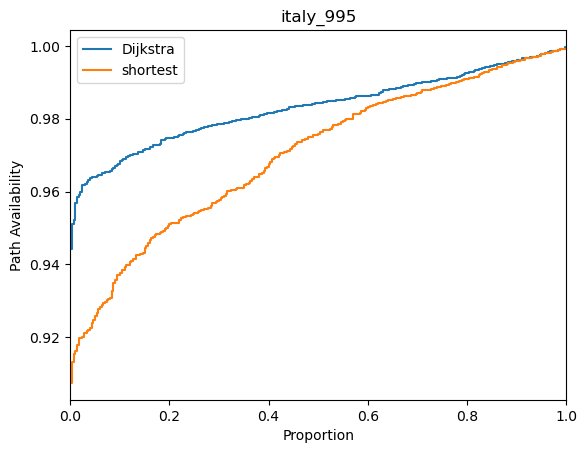

In [19]:
sns.ecdfplot(data=resDf, y = "avb_djk", label = "Dijkstra")
#sns.ecdfplot(data=resDf, y = "avb_fugg", label = "Független")
sns.ecdfplot(data=resDf, y = "avb_sht", label = "shortest")
plt.ylabel("Path Availability")
plt.legend()
plt.title(network)
plt.show()

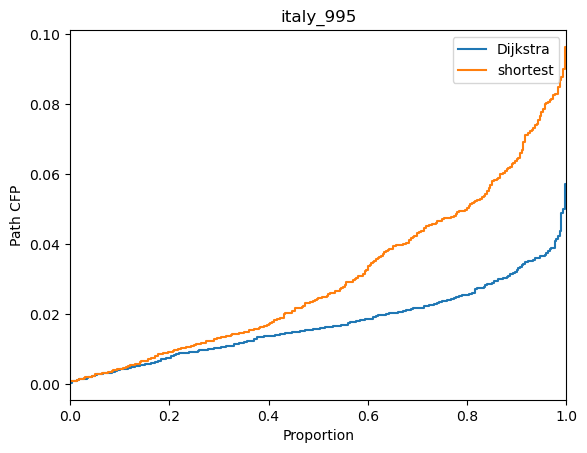

In [12]:
sns.ecdfplot(data=resDf, y = "err_djk", label = "Dijkstra")
sns.ecdfplot(data=resDf, y = "err_sht", label = "shortest")
plt.ylabel("Path CFP")
plt.legend()
plt.title(network)
plt.show()

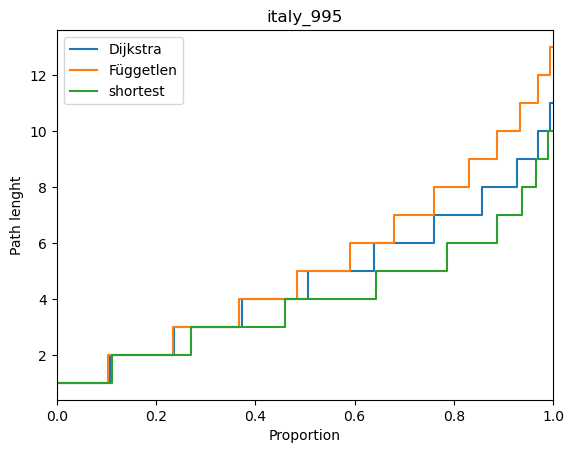

In [13]:
sns.ecdfplot(data=resDf, y = "len_djk", label = "Dijkstra")
sns.ecdfplot(data=resDf, y = "len_fugg", label = "Független")
sns.ecdfplot(data=resDf, y = "len_sht", label = "shortest")
plt.ylabel("Path lenght")
plt.legend()
plt.title(network)
plt.show()

<Axes: xlabel='Proportion', ylabel='pct_err'>

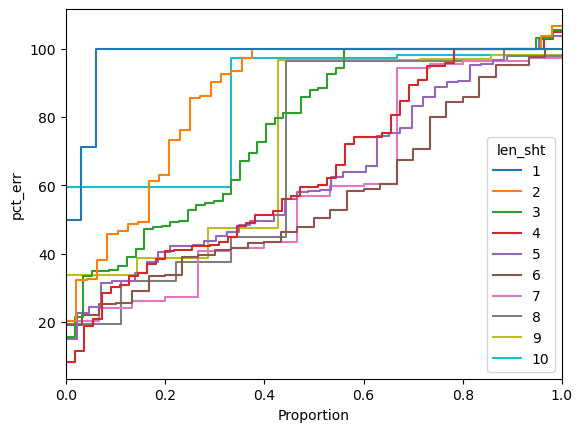

In [15]:
sns.ecdfplot(data=resDf, y = "pct_err", hue="len_sht", palette="tab10")

<Axes: xlabel='len_sht', ylabel='value'>

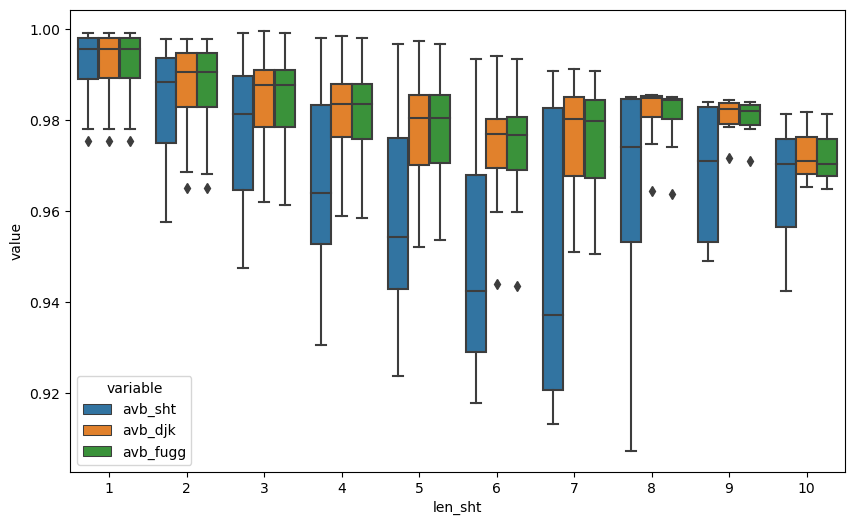

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(data=pd.melt(resDf[["avb_sht", "avb_djk", "avb_fugg", "len_sht"]], id_vars=["len_sht"]),
            x = "len_sht", y = "value", hue="variable")